In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHLZs_dhWi5jNM6-dC79SnRZvYJiTuMkrTMjIJKQa8s6bk35VAfs2s
Mounted at /content/drive


In [ ]:
import numpy as np
import pickle as pkl
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from google.colab.patches import cv2_imshow
%matplotlib nbagg

In [ ]:
path = "/content/drive/My Drive/Aruco/data"
imagesFolder = path+"/images/"

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
fig = plt.figure()
nx = 8
ny = 6
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i-1, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig(path + "/markers.pdf")    
plt.show()
plt.close()

<IPython.core.display.Javascript object>

In [ ]:
board = aruco.CharucoBoard_create(3, 3, 1, 0.8, aruco_dict)
imboard = board.draw((4000, 4000))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
#cv2.imwrite(imagesFolder + "/chessboard.tiff",imboard)
plt.savefig(path + "/chessboard.pdf")   
plt.grid()
plt.show()
print("Imprimer le damier de calibration!")

<IPython.core.display.Javascript object>

Imprimer le damier de calibration!


In [ ]:
import cv2
import math
videoFile = path+"/output.avi"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId <300):
        filename = imagesFolder + "image_" +  str(int(frameId)) + ".jpg"
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [ ]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    
    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              

        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize
    print("finished")

In [ ]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors
    print("finished")

In [ ]:
#%%time
images = [imagesFolder + f for f in os.listdir(imagesFolder) if f.startswith("image_")]
allCorners,allIds,imsize = read_chessboards(images)


POSE ESTIMATION STARTS:
=> Processing image /content/drive/My Drive/Aruco/data/images/image_0.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_1.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_2.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_3.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_4.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_5.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_6.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_7.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_8.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_9.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_10.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_11.jpg
=> Processing image /content/drive/My Drive/Aruco/data/images/image_12.jpg
=> Processi

In [ ]:
%%time
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
ret

CAMERA CALIBRATION
CPU times: user 18min 14s, sys: 105 ms, total: 18min 15s
Wall time: 18min 15s


In [ ]:
np.savetxt(path+"/calib_mtx_webcam.csv", mtx)
np.savetxt(path+"/calib_dist_webcam.csv", dist)
fileObject1 = open(path+"/calib_mtx_webcam.pkl", 'wb')
fileObject2 = open(path+"/calib_dist_webcam.pkl", 'wb')
pkl.dump(mtx, fileObject1)
fileObject1.close()
pkl.dump(dist, fileObject2)
fileObject2.close()

In [ ]:
mtx=np.load(path+'/calib_mtx_webcam.pkl', allow_pickle=True)
dist=np.load(path+'/calib_dist_webcam.pkl', allow_pickle=True)

In [ ]:
i=24 # select image id
plt.figure()
frame = cv2.imread(imagesFolder + "image_100.jpg".format(i))
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(211)
cv2_imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(212)
cv2_imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

In [ ]:
%%time
frame = cv2.imread(imagesFolder + "image_15.jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

CPU times: user 22 ms, sys: 5.08 ms, total: 27.1 ms
Wall time: 28.6 ms


<IPython.core.display.Javascript object>

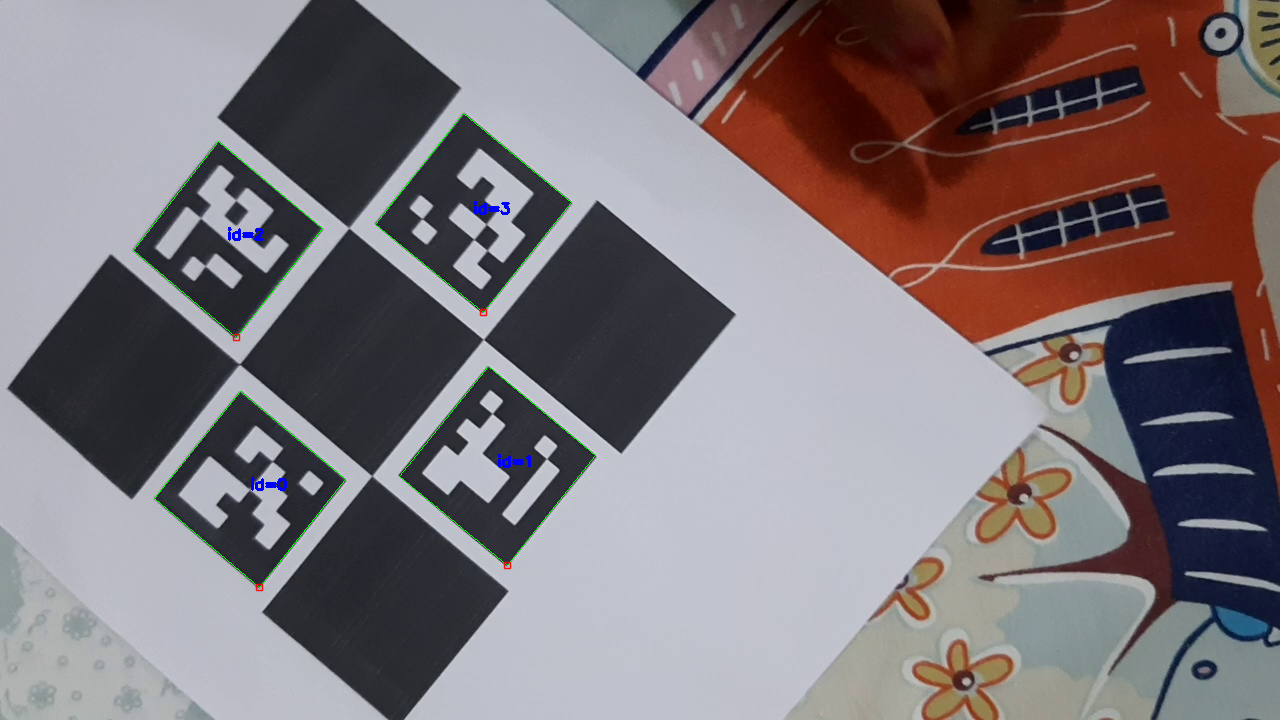

No handles with labels found to put in legend.


In [ ]:
conn = np.array([0, 1, 2, 3, 0])
plt.figure()
cv2_imshow(frame_markers)
plt.legend()
plt.show()

In [ ]:
size_of_marker =  0.0145 # side lenght of the marker in meter
rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [ ]:
length_of_axis = 0.01
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>

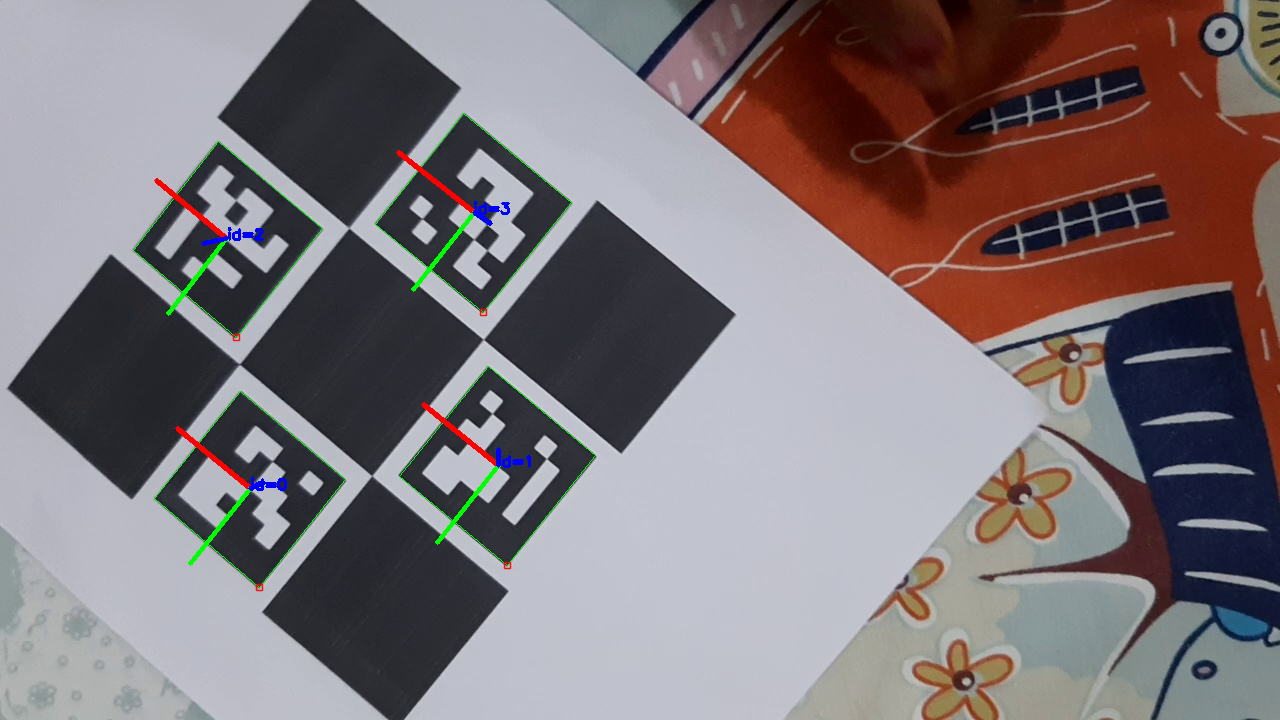

In [ ]:
plt.figure()
cv2_imshow(imaxis)
plt.show()